In [115]:
import pickle
import matplotlib.pyplot as plt
import glob
from utils import helper_funcs
import numpy as np
import networkx as nx

In [108]:
def load(dirname):
    '''
    Load the best-of-5 simulation results for each benchmark graph in the given directory
    '''
    all_graphs = glob.glob(dirname + 'G*')
    all_pickles = []
    for benchmark_graph in all_graphs:
        pickle_fns = glob.glob(benchmark_graph + '/*pickle')
        temp_list = []
        for pickle_fn in pickle_fns:
            with open(pickle_fn, 'rb') as pklfile:
                cur_pickle = pickle.load(pklfile)
            temp_list.append(cur_pickle)
        
        # Select the best of the repetitions
        best_mis = 0
        best_rep = None
        for pkl_result in temp_list:
            final_mis = helper_funcs.hamming_weight(pkl_result[1][-1][0])
            if final_mis > best_mis:
                best_rep = pkl_result
                best_mis = final_mis
        all_pickles.append((best_rep, benchmark_graph))
    return all_pickles

def get_classical_results(kind, graphtype):
    if kind == 'bh':
        result_dir = 'boppana-halldorsson'
    elif kind == 'dc':
        result_dir = 'classical_divide_and_conquer'
    else:
        raise ValueError(f'Unknown classical algorithm: {kind}')
    
    all_graphs = glob.glob(f'benchmark_results/{result_dir}/{graphtype}_graphs/G*')
    approx_ratios = []
    for graph_dir in all_graphs:
        all_reps = glob.glob(graph_dir + '/*.txt')
        best_mis = 0
        for rep in all_reps:
            with open(rep, 'r') as repfn:
                for l, line in enumerate(repfn):
                    if l == 1:
                        if kind == 'bh':
                            cur_mis = int(line.split()[-1])
                        elif kind == 'dc':
                            cur_mis = int(line.split()[-1].strip(']'))
            if cur_mis > best_mis:
                best_mis = cur_mis
        
        # Get the optimal mis for this graph
        graphnum = graph_dir.split('/')[-1]
        with open(f'benchmark_graphs/brute_force_outputs/{graphtype}_graphs/{graphnum}_brute_force.out', 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        approx_ratios.append(best_mis / optimal_mis)
    return np.mean(approx_ratios)

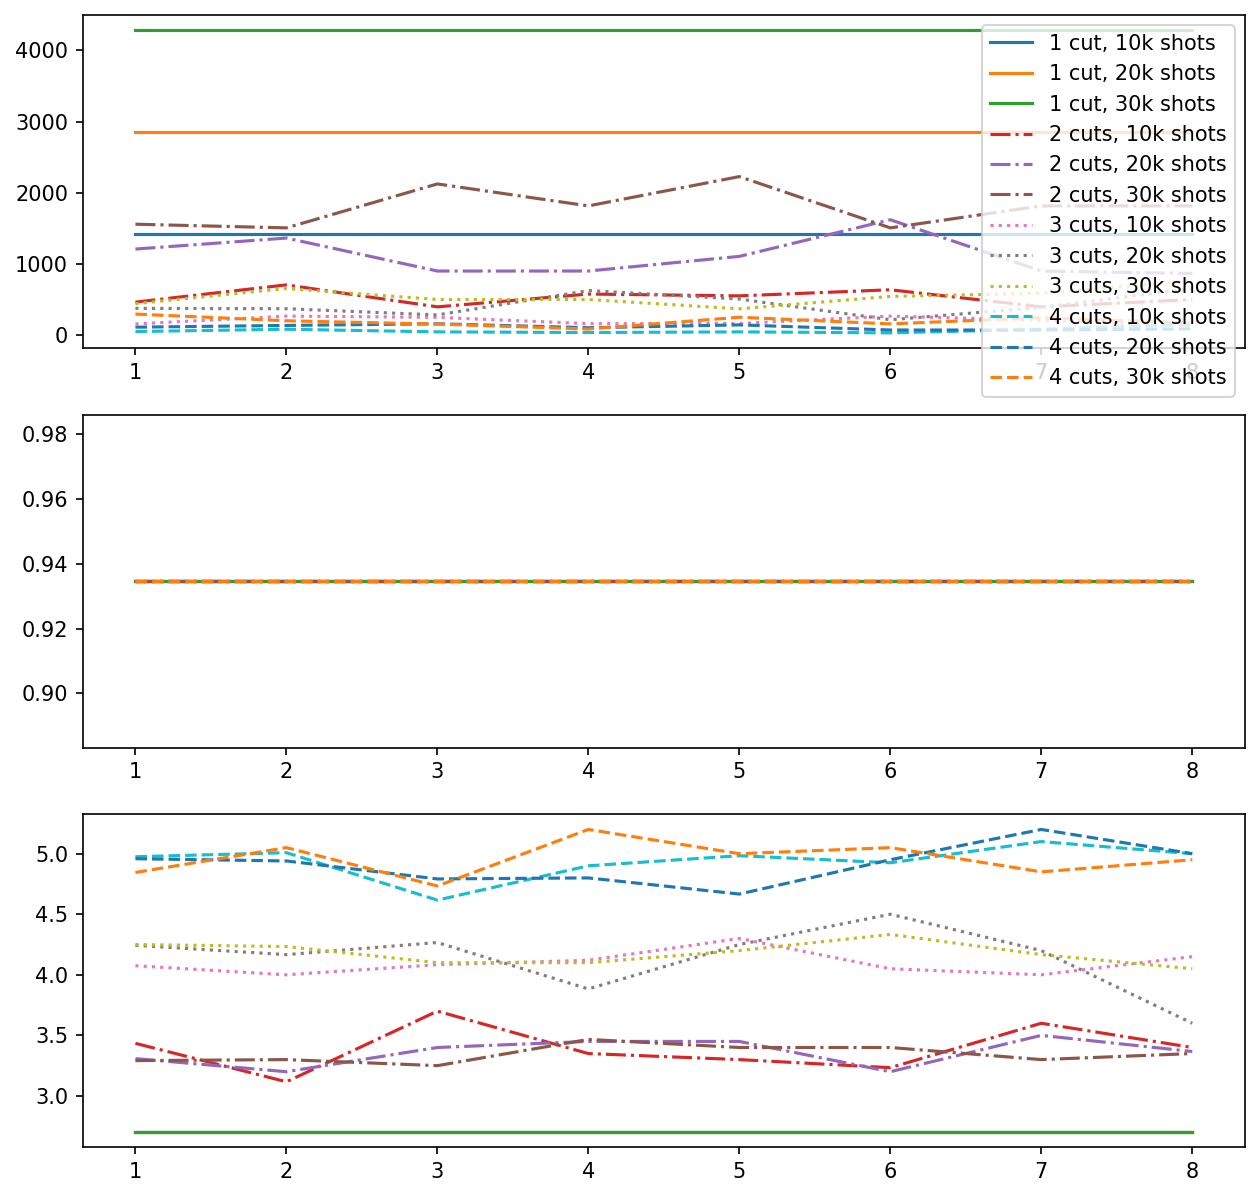

In [63]:
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=3, ncols=1, figsize=[10,10])

benchmarks = ['N26_d3_2frags_1cuts_10000shots/', 'N26_d3_2frags_1cuts_20000shots/', 'N26_d3_2frags_1cuts_30000shots/',
              'N26_d3_2frags_2cuts_10000shots/', 'N26_d3_2frags_2cuts_20000shots/', 'N26_d3_2frags_2cuts_30000shots/',
              'N26_d3_2frags_3cuts_10000shots/', 'N26_d3_2frags_3cuts_20000shots/', 'N26_d3_2frags_3cuts_30000shots/',
              'N26_d3_2frags_4cuts_10000shots/', 'N26_d3_2frags_4cuts_20000shots/', 'N26_d3_2frags_4cuts_30000shots/',]
labels = ['1 cut, 10k shots', '1 cut, 20k shots', '1 cut, 30k shots',
          '2 cuts, 10k shots', '2 cuts, 20k shots', '2 cuts, 30k shots',
          '3 cuts, 10k shots', '3 cuts, 20k shots', '3 cuts, 30k shots',
          '4 cuts, 10k shots', '4 cuts, 20k shots', '4 cuts, 30k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    # How many fragment shots, cut ratio, number of partial mixers?
    frag_shots_results = []
    cut_ratio_results = []
    num_partialmixers_results = []
    for (graph, sim_result), _ in data:
        temp_fs, temp_cr, temp_pm = [], [], []
        for i, partition_round in enumerate(sim_result):
            cut_nodes = partition_round[-2]
            temp_cr.append(len(cut_nodes) / graph.number_of_nodes())
            
            history = partition_round[-1][0]
            frag_shots = []
            num_parmix = []
            for inner_round in history:
                frag_shots.append(inner_round['frag_shots'])
                num_parmix.append(inner_round['num_params'] - 1)
            
            temp_fs.append(np.mean(frag_shots))
            temp_pm.append(np.mean(num_parmix))
        
        frag_shots_results.append(temp_fs)
        cut_ratio_results.append(temp_cr)
        num_partialmixers_results.append(temp_pm)
    
    avg_fs = np.mean(frag_shots_results, axis=0)
    avg_cr = np.mean(cut_ratio_results, axis=0)
    avg_pm = np.mean(num_partialmixers_results, axis=0)
    
    xvals = np.arange(1,len(avg_fs)+1)
    
    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])
    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])
    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])
    
ax[0].legend()
plt.show()
plt.close()

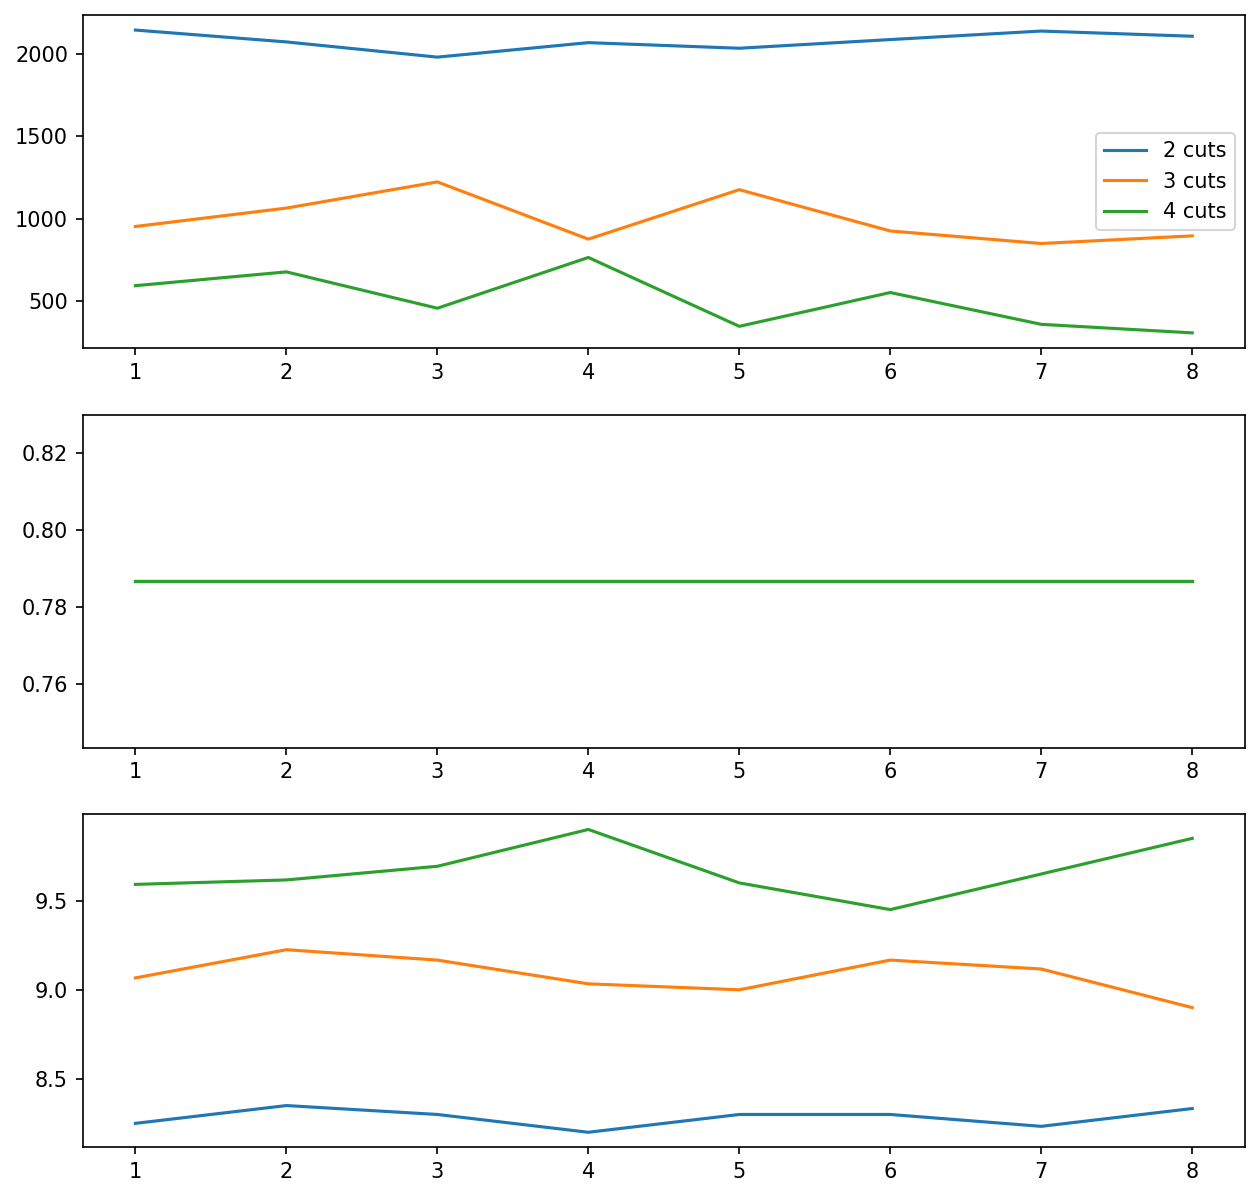

In [112]:
# Average number of fragment shots, cut ratio, number of partial mixers over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=3, ncols=1, figsize=[10,10])

benchmarks = ['N30_com3_pin20_pout2_3frags_2cuts_40000shots/',
              'N30_com3_pin20_pout2_3frags_3cuts_40000shots/',
              'N30_com3_pin20_pout2_3frags_4cuts_40000shots/',]
labels = ['2 cuts', '3 cuts', '4 cuts']
linestyles = ['-', '-', '-',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    # How many fragment shots, cut ratio, number of partial mixers?
    frag_shots_results = []
    cut_ratio_results = []
    num_partialmixers_results = []
    for (graph, sim_result), _ in data:
        temp_fs, temp_cr, temp_pm = [], [], []
        for i, partition_round in enumerate(sim_result):
            cut_nodes = partition_round[-2]
            temp_cr.append(len(cut_nodes) / graph.number_of_nodes())
            
            history = partition_round[-1][0]
            frag_shots = []
            num_parmix = []
            for inner_round in history:
                frag_shots.append(inner_round['frag_shots'])
                num_parmix.append(inner_round['num_params'] - 1)
            
            temp_fs.append(np.mean(frag_shots))
            temp_pm.append(np.mean(num_parmix))
        
        frag_shots_results.append(temp_fs)
        cut_ratio_results.append(temp_cr)
        num_partialmixers_results.append(temp_pm)
    
    avg_fs = np.mean(frag_shots_results, axis=0)
    avg_cr = np.mean(cut_ratio_results, axis=0)
    avg_pm = np.mean(num_partialmixers_results, axis=0)
    
    xvals = np.arange(1,len(avg_fs)+1)
    
    ax[0].plot(xvals, avg_fs, label=labels[idx], ls=linestyles[idx])
    ax[1].plot(xvals, avg_cr, label=labels[idx], ls=linestyles[idx])
    ax[2].plot(xvals, avg_pm, label=labels[idx], ls=linestyles[idx])
    
ax[0].legend()
plt.show()
plt.close()

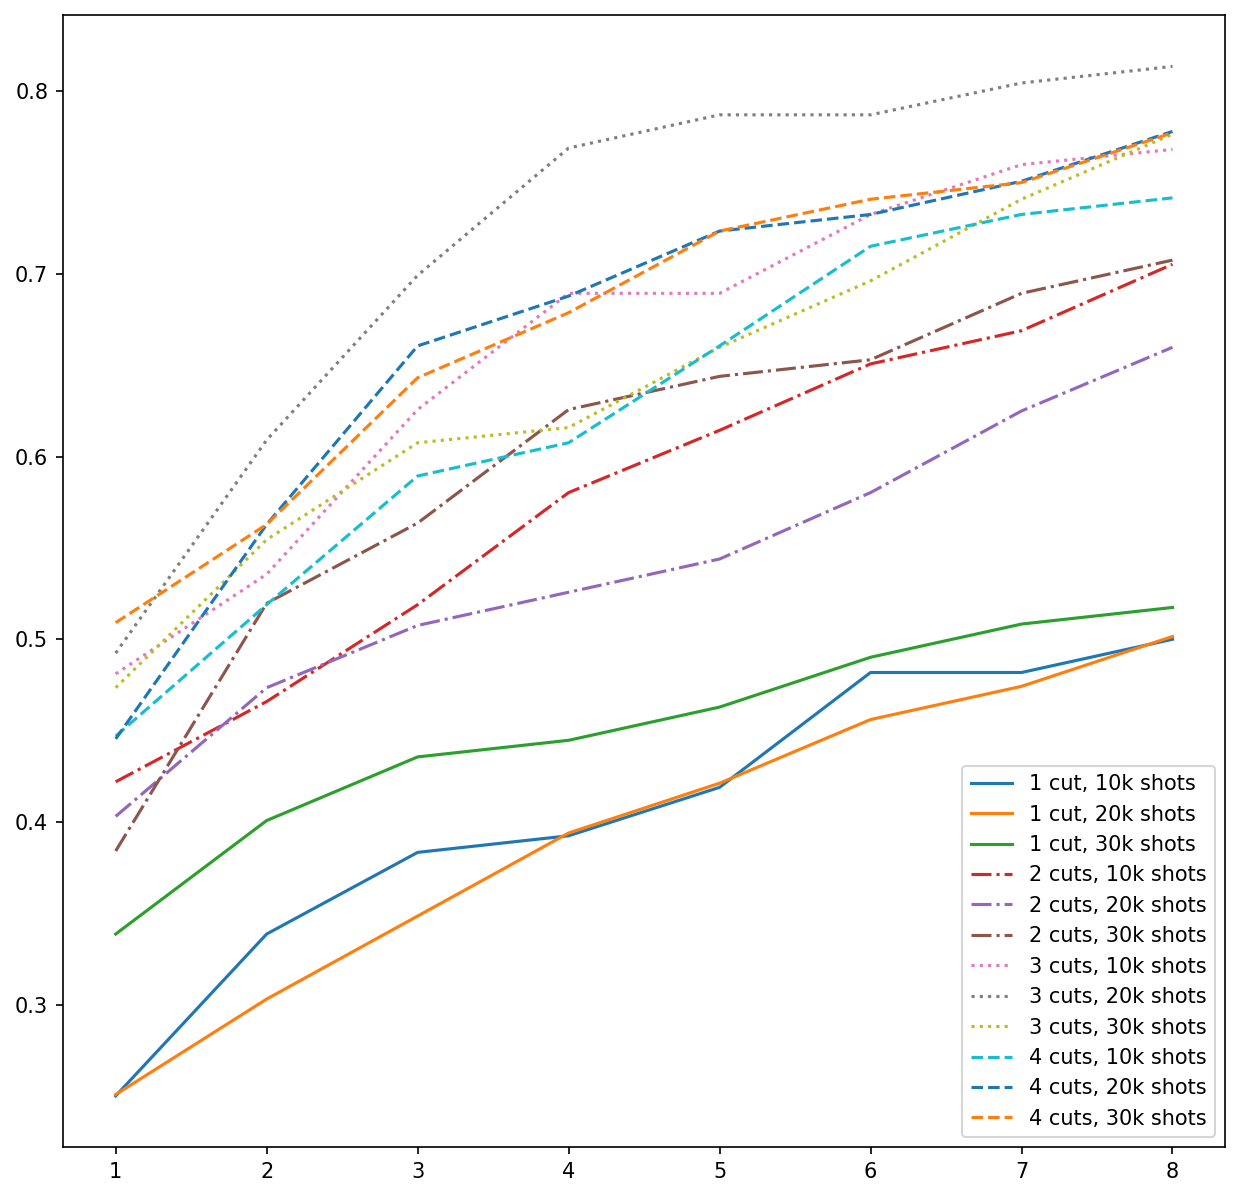

In [85]:
# Average approximation ratio over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=1, figsize=[10,10])

benchmarks = ['N26_d3_2frags_1cuts_10000shots/', 'N26_d3_2frags_1cuts_20000shots/', 'N26_d3_2frags_1cuts_30000shots/',
              'N26_d3_2frags_2cuts_10000shots/', 'N26_d3_2frags_2cuts_20000shots/', 'N26_d3_2frags_2cuts_30000shots/',
              'N26_d3_2frags_3cuts_10000shots/', 'N26_d3_2frags_3cuts_20000shots/', 'N26_d3_2frags_3cuts_30000shots/',
              'N26_d3_2frags_4cuts_10000shots/', 'N26_d3_2frags_4cuts_20000shots/', 'N26_d3_2frags_4cuts_30000shots/',]
labels = ['1 cut, 10k shots', '1 cut, 20k shots', '1 cut, 30k shots',
          '2 cuts, 10k shots', '2 cuts, 20k shots', '2 cuts, 30k shots',
          '3 cuts, 10k shots', '3 cuts, 20k shots', '3 cuts, 30k shots',
          '4 cuts, 10k shots', '4 cuts, 20k shots', '4 cuts, 30k shots',]
linestyles = ['-', '-', '-',
              '-.', '-.', '-.',
              ':', ':', ':',
              '--', '--', '--',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    approx_ratio_results = []
    for (graph, sim_result), benchmark_graph in data:
        # Get the optimal mis for this graph
        parts = benchmark_graph.split('/')
        brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
        with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        
        # Average of the QDC results
        temp_ar = []
        for i, partition_round in enumerate(sim_result):
            best_indset = partition_round[0]
            temp_ar.append(helper_funcs.hamming_weight(best_indset) / optimal_mis)
        
        approx_ratio_results.append(temp_ar)
    
    avg_ar = np.mean(approx_ratio_results, axis=0)
    
    xvals = np.arange(1,len(avg_ar)+1)
    
    ax.plot(xvals, avg_ar, label=labels[idx], ls=linestyles[idx])
    
ax.legend()
plt.show()
plt.close()

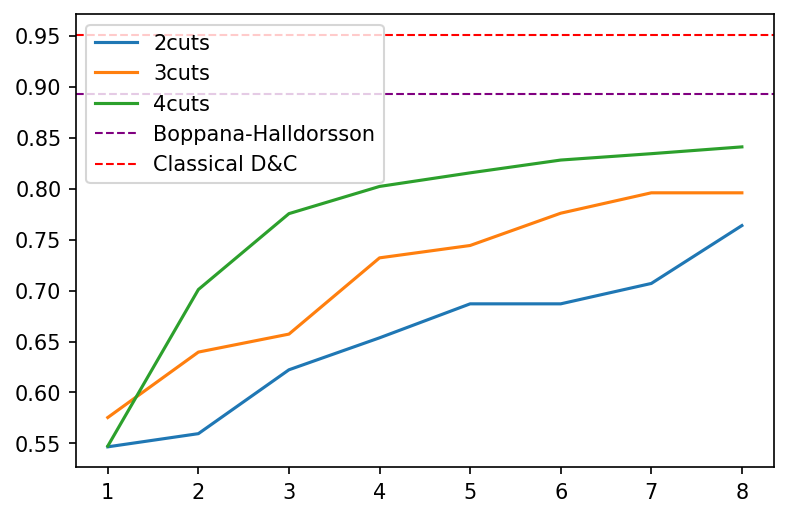

In [111]:
# Average approximation ratio over partition rounds
fig, ax = plt.subplots(dpi=150, nrows=1, ncols=1)

benchmarks = ['N30_com3_pin20_pout2_3frags_2cuts_40000shots/',
              'N30_com3_pin20_pout2_3frags_3cuts_40000shots/',
              'N30_com3_pin20_pout2_3frags_4cuts_40000shots/',]
labels = ['2cuts', '3cuts', '4cuts']
linestyles = ['-', '-', '-',]
for idx, benchmark in enumerate(benchmarks):
    data = load('benchmark_results/ISCA_results/COBYLA/' + benchmark)
    
    approx_ratio_results = []
    for (graph, sim_result), benchmark_graph in data:
        # Get the optimal mis for this graph
        parts = benchmark_graph.split('/')
        brute_force_dir = parts[-2].split('frags')[0][:-1] + 'graphs/' + parts[-1] + '_brute_force.out'
        with open('benchmark_graphs/brute_force_outputs/' + brute_force_dir, 'r') as bf_file:
            for l, line in enumerate(bf_file):
                if l == 1:
                    optimal_mis = int(line.split()[-1])
        
        # Average of the QDC results
        temp_ar = []
        for i, partition_round in enumerate(sim_result):
            best_indset = partition_round[0]
            temp_ar.append(helper_funcs.hamming_weight(best_indset) / optimal_mis)
        
        approx_ratio_results.append(temp_ar)
    
    avg_ar = np.mean(approx_ratio_results, axis=0)
    
    xvals = np.arange(1,len(avg_ar)+1)
    
    ax.plot(xvals, avg_ar, label=labels[idx], ls=linestyles[idx])
    
# Plot the classical comparison
ax.axhline(get_classical_results('bh', 'N30_com3_pin20_pout2'), label='Boppana-Halldorsson', ls='--', lw=1, c='purple')
ax.axhline(get_classical_results('dc', 'N30_com3_pin20_pout2'), label='Classical D&C', ls='--', lw=1, c='r')
    
ax.legend()
plt.show()
plt.close()

In [127]:
def plot_subgraphs(rep_file):
    with open(rep_file, 'rb') as pklfile:
        data = pickle.load(pklfile)
        
    G = data[0]
    full_history = data[1]
    for i, partition_round in enumerate(full_history):
        partition = partition_round[4]
        cut_nodes = partition_round[5]
        print(i, partition, len(cut_nodes) / len(G.nodes))

    print(cut_nodes)
    colors = ['gold', 'skyblue', 'tab:orange', 'lightgreen']
    node_color = [None] * len(G.nodes)
    for i, subgraph in enumerate(partition):
        for node in subgraph:
            node_color[node] = colors[i]
    nx.draw_spring(G, with_labels=True, node_color=node_color)

0 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
1 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
2 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
3 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
4 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
5 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
6 [[0, 1, 16, 23, 24, 25, 26, 27, 28, 29], [8, 9, 14, 15, 17, 18, 19, 20, 21, 22], [2, 3, 4, 5, 6, 7, 10, 11, 12, 13]] 0.7333333333333333
7 [[0, 1, 16, 23, 24, 25, 26, 27, 

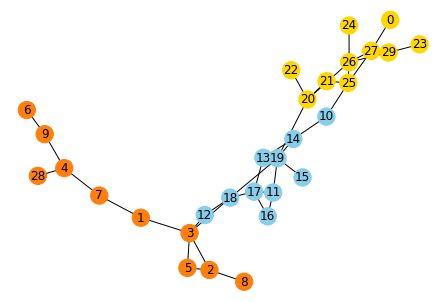

In [128]:
plot_subgraphs('benchmark_results/ISCA_results/COBYLA/N30_com3_pin20_pout2_3frags_2cuts_40000shots/G2/dqva_G2_2cuts_rep1.pickle')